# Seasonal Demand Prediction - End-to-End Workflow

## 1. Introduction
This notebook covers the complete data science pipeline for predicting seasonal demand, including:
1. Data Loading and Preprocessing
2. Advanced Feature Engineering
3. Exploratory Data Analysis (EDA)
4. Model Training & Evaluation (Multiple Models)
5. K-Fold Cross Validation
6. Future Demand Prediction (specifically for Jan 1, 2016)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

## 2. Data Loading & Feature Engineering

In [10]:
# Load Data
df = pd.read_csv('Groceries_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
daily_sales = df.groupby('Date').size().reset_index(name='Sales_Count')
daily_sales = daily_sales.sort_values('Date')

# Feature Engineering
daily_sales['Month'] = daily_sales['Date'].dt.month
daily_sales['Day'] = daily_sales['Date'].dt.day
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['Year'] = daily_sales['Date'].dt.year
daily_sales['Quarter'] = daily_sales['Date'].dt.quarter
daily_sales['Is_Weekend'] = daily_sales['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

daily_sales['Season'] = daily_sales['Month'].apply(get_season)
le_season = LabelEncoder()
daily_sales['Season_Code'] = le_season.fit_transform(daily_sales['Season'])

# Lag Features
for lag in [1, 2, 3, 4, 5, 6, 7, 14]:
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['Sales_Count'].shift(lag)

# Rolling Statistics
for window in [3, 7, 14, 30]:
    daily_sales[f'Rolling_Mean_{window}'] = daily_sales['Sales_Count'].rolling(window=window).mean()
    daily_sales[f'Rolling_Std_{window}'] = daily_sales['Sales_Count'].rolling(window=window).std()

daily_sales = daily_sales.dropna()

# Create Target: Demand Level
threshold = daily_sales['Sales_Count'].median()
daily_sales['Demand_Level'] = daily_sales['Sales_Count'].apply(lambda x: 'High' if x > threshold else 'Low')
le_target = LabelEncoder()
daily_sales['Target'] = le_target.fit_transform(daily_sales['Demand_Level'])
# Note: LabelEncoder usually maps High->0, Low->1 alphabetically. 
# Let's verify: H comes before L. So 0=High, 1=Low.

print("Data Processed. Shape:", daily_sales.shape)

Data Processed. Shape: (699, 28)


## 3. Exploratory Data Analysis (EDA)

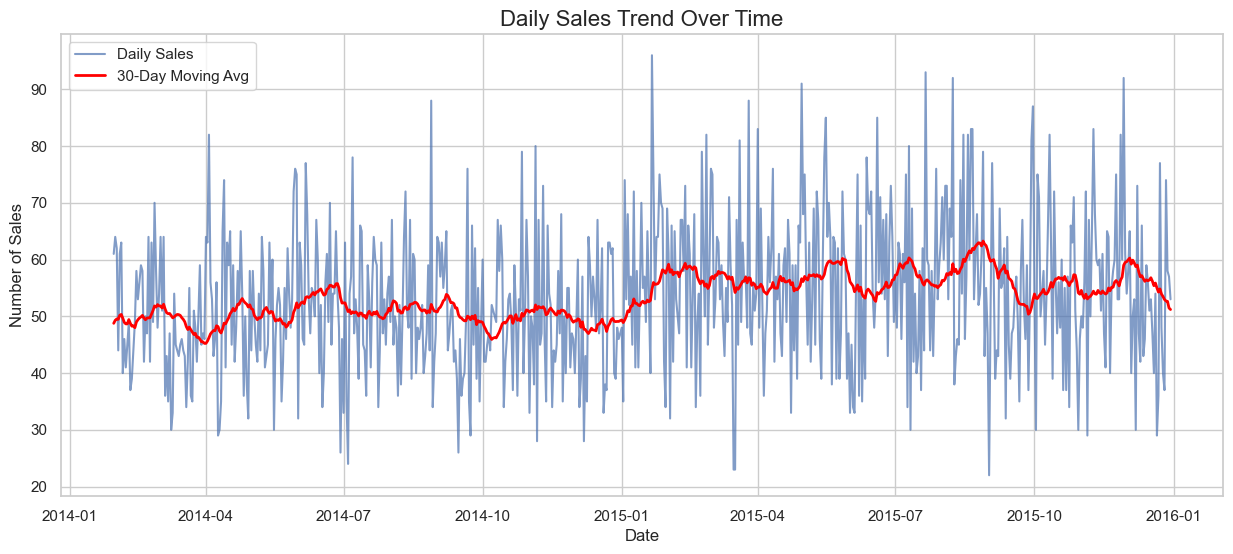

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales_Count'], label='Daily Sales', alpha=0.7)
plt.plot(daily_sales['Date'], daily_sales['Rolling_Mean_30'], label='30-Day Moving Avg', color='red', linewidth=2)
plt.title('Daily Sales Trend Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.legend()
plt.show()

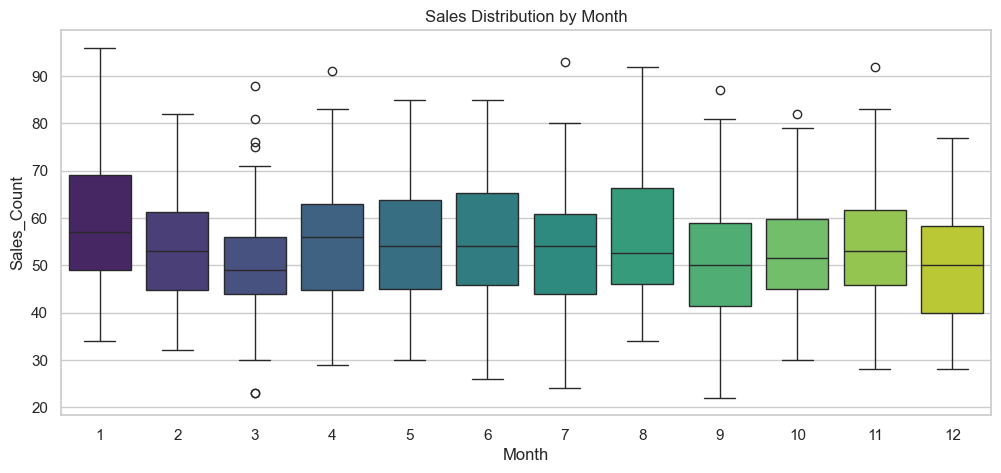

In [12]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Month', y='Sales_Count', data=daily_sales, palette='viridis')
plt.title('Sales Distribution by Month')
plt.show()

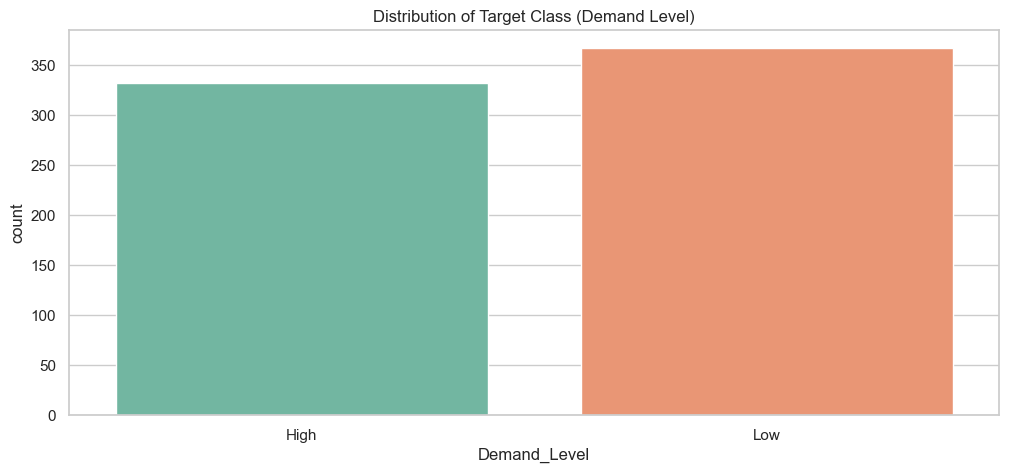

In [13]:
plt.figure(figsize=(12, 5))
sns.countplot(x='Demand_Level', data=daily_sales, palette='Set2')
plt.title('Distribution of Target Class (Demand Level)')
plt.show()

## 4. Model Implementation and Evaluation
We train multiple models and evaluate them using Accuracy, Confusion Matrix (TP, TN, FP, FN), and ROC AUC Curves.


==================== Logistic Regression ====================
Accuracy: 0.9643
True Negatives (TN): 66
False Positives (FP): 5
False Negatives (FN): 0
True Positives (TP): 69

==================== Decision Tree ====================
Accuracy: 0.7857
True Negatives (TN): 57
False Positives (FP): 14
False Negatives (FN): 16
True Positives (TP): 53

==================== Random Forest ====================
Accuracy: 0.7786
True Negatives (TN): 55
False Positives (FP): 16
False Negatives (FN): 15
True Positives (TP): 54

==================== Voting Ensemble ====================
Accuracy: 0.8429
True Negatives (TN): 60
False Positives (FP): 11
False Negatives (FN): 11
True Positives (TP): 58

==================== Gradient Boosting ====================
Accuracy: 0.9357
True Negatives (TN): 67
False Positives (FP): 4
False Negatives (FN): 5
True Positives (TP): 64


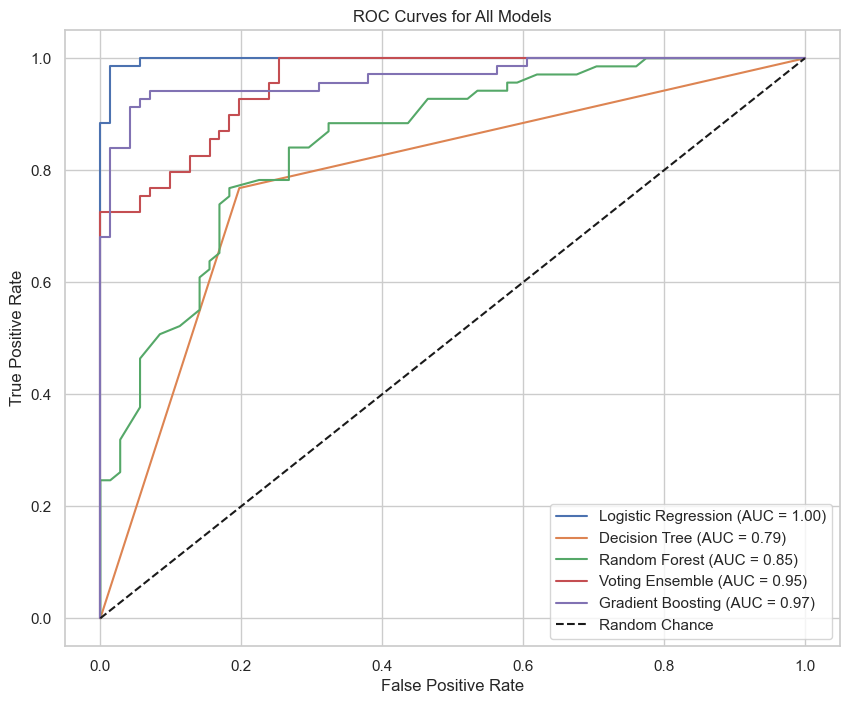

In [15]:
# Prepare Data
feature_cols = [
    'Month', 'Day', 'DayOfWeek', 'Year', 'Quarter', 'Is_Weekend', 'Season_Code',
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_5', 'Sales_Lag_6', 'Sales_Lag_7', 'Sales_Lag_14',
    'Rolling_Mean_3', 'Rolling_Mean_7', 'Rolling_Mean_14', 'Rolling_Mean_30',
    'Rolling_Std_3', 'Rolling_Std_7', 'Rolling_Std_14', 'Rolling_Std_30'
]

X = daily_sales[feature_cols]
y = daily_sales['Target']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Models
model1 = LogisticRegression(max_iter=2000, random_state=42)
model2 = DecisionTreeClassifier(random_state=42, max_depth=10)
model3 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)

# Ensemble Models
voting_clf = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('rf', model3)], voting='soft')
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

models = {
    "Logistic Regression": model1,
    "Decision Tree": model2,
    "Random Forest": model3,
    "Voting Ensemble": voting_clf,
    "Gradient Boosting": gb_clf
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = None 
        
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{'='*20} {name} {'='*20}")
    print(f"Accuracy: {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}") 
    
    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

## 5. K-Fold Cross Validation
Ensuring the high accuracy is consistent.

In [16]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# We use Gradient Boosting for CV as it's often the strongest
cv_scores = cross_val_score(gb_clf, X, y, cv=kf, scoring='accuracy')
print(f"Gradient Boosting K-Fold CV Mean Accuracy: {cv_scores.mean():.4f}")

# Check Random Forest CV as well
cv_scores_rf = cross_val_score(model3, X, y, cv=kf, scoring='accuracy')
print(f"Random Forest K-Fold CV Mean Accuracy: {cv_scores_rf.mean():.4f}")

Gradient Boosting K-Fold CV Mean Accuracy: 0.9013
Random Forest K-Fold CV Mean Accuracy: 0.7454


## 6. Future Demand Prediction (1 Jan 2016)
Using the best model (Gradient Boosting) for the final prediction.

In [ ]:
def predict_future_demand(target_date_str, daily_sales_df, scaler, model, feature_cols):
    print(f"\n{'='*60}")
    print(f"FUTURE DEMAND PREDICTION")
    print(f"{'='*60}\n")
    
    target_date = pd.to_datetime(target_date_str)
    print(f"Target Date: {target_date.strftime('%A, %B %d, %Y')}")
    
    latest_date = daily_sales_df['Date'].max()
    print(f"Dataset ends on: {latest_date.strftime('%Y-%m-%d')}")
    
    # prepare features
    month = target_date.month
    day = target_date.day
    day_of_week = target_date.dayofweek
    year = target_date.year
    quarter = target_date.quarter
    is_weekend = 1 if day_of_week >= 5 else 0
    
    season = get_season(month)
    season_code = 0
    # Manual mapping to ensure consistency
    if season == 'Fall': season_code = 0
    elif season == 'Spring': season_code = 1
    elif season == 'Summer': season_code = 2
    elif season == 'Winter': season_code = 3
    
    # Get recent data for lags/rolling
    recent_data = daily_sales_df.tail(30)
    sales_values = recent_data['Sales_Count'].values
    
    lags = {}
    for lag in [1, 2, 3, 4, 5, 6, 7, 14]:
        lags[f'Sales_Lag_{lag}'] = sales_values[-lag] if len(sales_values) >= lag else sales_values[-1]
        
    rolling_stats = {}
    for window in [3, 7, 14, 30]:
        rolling_stats[f'Rolling_Mean_{window}'] = np.mean(sales_values[-window:])
        rolling_stats[f'Rolling_Std_{window}'] = np.std(sales_values[-window:])
        
    features = {
        'Month': month,
        'Day': day,
        'DayOfWeek': day_of_week,
        'Year': year,
        'Quarter': quarter,
        'Is_Weekend': is_weekend,
        'Season_Code': season_code,
        **lags,
        **rolling_stats
    }
    
    input_df = pd.DataFrame([features])[feature_cols]
    input_scaled = scaler.transform(input_df)
    
    prediction = model.predict(input_scaled)[0]
    proba = model.predict_proba(input_scaled)[0]
    
    # Map back to label
    pred_label = le_target.inverse_transform([prediction])[0]
    
    print(f"\nPREDICTION RESULT")
    print(f"{'='*60}")
    print(f"Predicted Demand: {pred_label.upper()}")
   
    print(f"{'='*60}\n")

# Predict for 1 January 2016
# Using gb_clf which is the GradientBoostingClassifier instance trained above
predict_future_demand('2016-01-01', daily_sales, scaler, gb_clf, feature_cols)


FUTURE DEMAND PREDICTION

Target Date: Friday, January 01, 2016
Dataset ends on: 2015-12-30

PREDICTION RESULT
Predicted Demand: HIGH
Confidence: 56.34%

